# Running models on the testing set!

In this notebook you can load any model we provided, and run it on the testing set we used.

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from datasets import load_dataset
import numpy as np

In [25]:
# TODO: change this to any model you want:
model_path = "./best_bertje"

# TODO: change the value of the bool accordingly:
dutch_model = True # Only true if the model was trained for NLI in Dutch
cols = ["sentence_A", "sentence_B"] if dutch_model else ["sentence_A_original", "sentence_B_original"]

model = AutoModelForSequenceClassification.from_pretrained(model_path).eval()
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [26]:
# Getting the dataset:

# Tokenizing the dataset:
def tokenize_data(data):
    inp = [data[col] for col in cols]
    return tokenizer(*inp, truncation=True)

testing_set = load_dataset("maximedb/sick_nl", split="train+test+validation")
testing_set = testing_set.map(tokenize_data, batched=True)

# Turning the labels into the same format models were trained on:
label_remap = {
    "A_entails_B": 0,
    "A_neutral_B": 1,
    "A_contradicts_B": 2
}
testing_set = testing_set.map(
    lambda x: {"label": label_remap[x["entailment_AB"]]})

Map: 100%|██████████| 9840/9840 [00:01<00:00, 5030.62 examples/s]


In [27]:
# Testing the model:

# This compute_metrics function actually just gives you all the datapoints:
def compute_metrics(predictions):
    logits, labels = predictions
    predictions = np.argmax(logits, axis=-1)
    return {
        "true_label": labels,
        "prediction": predictions
    }

# Getting a trainer for easy evaluation:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

results = trainer.predict(testing_set).metrics
true_labels = results["test_true_label"]
predictions = results["test_prediction"]

/home/vincent/Documenten/Natural_Language_Processing/nlp_proj_env/lib64/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
100%|██████████| 1230/1230 [00:15<00:00, 80.66it/s]


### Using Scikit Learn to see some results

Accuracy:           0.57429
Balanced accuracy:  0.68484


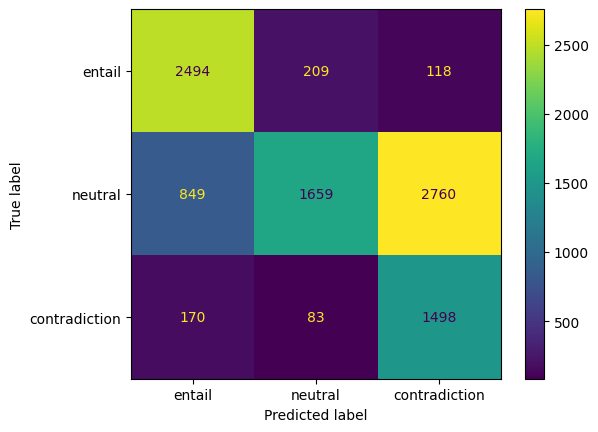

In [28]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print(f"Accuracy:           {accuracy_score(true_labels, predictions):.5}")
print(f"Balanced accuracy:  {balanced_accuracy_score(true_labels, predictions):.5}")

conf_m = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(conf_m, display_labels=["entail", "neutral", "contradiction"])
disp.plot()